### load

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import time
import pandas as pd
from IPython.display import display
from utils import nba_inference_utils as niu
import matplotlib.pyplot as plt
import joblib 
import pprint as pp

# create pretty printer
pp = pp.PrettyPrinter(indent=4)
import warnings
warnings.simplefilter(action='ignore')

train_cols = ['Opp_Elo', 'Opp_Momentum', 'SPREAD_LINE_MOVEMENT_1', 
              'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3', 
                'TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2',
                'TOTAL_LINE_MOVEMENT_3', 'CREW', 'Opp_Avg_3_game_DEFF',
                'Opp_Avg_5_game_DEFF', 'Opp_Season_Avg_DEFF',
                'Opp_Avg_3_game_OEFF', 'Opp_Avg_5_game_OEFF',
                'Opp_Season_Avg_OEFF', 'Opp_Avg_3_game_PACE',
                'Opp_Avg_5_game_PACE', 'Opp_Season_Avg_PACE',
                'Opp_Avg_3_game_POSS', 'Opp_Avg_5_game_POSS',
                'Opp_Season_Avg_POSS', 'Avg_3_game_DEFF',
                'Avg_5_game_DEFF', 'Season_Avg_DEFF',
                'Avg_3_game_OEFF', 'Avg_5_game_OEFF',
                'Season_Avg_OEFF', 'Avg_3_game_PACE',
                'Avg_5_game_PACE', 'Season_Avg_PACE',
                'Avg_3_game_POSS', 'Avg_5_game_POSS',
                'Season_Avg_POSS', 'Avg_3_game_OR', 'Avg_5_game_OR',
                'Season_Avg_OR','Avg_3_game_3P', 'Avg_5_game_3P',
                'Season_Avg_3P','Avg_3_game_3PA', 'Avg_5_game_3PA',
                'Season_Avg_3PA','Avg_3_game_TO', 'Avg_5_game_TO',
                'Season_Avg_TO','Avg_3_game_FT', 'Avg_5_game_FT',
                'Season_Avg_FT','CLOSING_SPREAD',
                'CLOSING_TOTAL', 'MONEYLINE', 'Avg_3_game_PTS',
                'Avg_5_game_PTS', 'Season_Avg_PTS', 'Last_ML_1',
                'Last_ML_2', 'Last_ML_3', 'VENUE', 'TEAM', 'Opponent',
                'Win_Loss_Diff', 'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL',
                'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME',
                'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS',
                'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)',
                'Elo_Rating', 'Momentum', 'MAIN REF', 'TEAM_REST_DAYS',
                    'Offensive_Rating', 'Defensive_Rating',
              'Opp_Offensive_Rating', 'Opp_Defensive_Rating', 'two_week_totals', 'Elo_Var', 'Opp_Elo_Var']

today_map_features = ['TEAM', 'Opponent', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'Venue', 'Referee', 
           'ELO_Rating', 'Momentum',
             'HOME TEAM WIN%', 'HOME TEAM POINTS DIFFERENTIAL',
             'Opp_Elo', 'Opp_Momentum', 'CREW',
              'TOTAL POINTS PER GAME', 'CALLED FOULS PER GAME',
              'FOUL% AGAINST ROAD TEAMS', 'FOUL% AGAINST HOME TEAMS',
              'FOUL DIFFERENTIAL (Against Road Team) - (Against Home Team)',
              'SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3',
              'TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3',  'Offensive_Rating', 'Defensive_Rating',
              'Opp_Offensive_Rating', 'Opp_Defensive_Rating', 'Elo_Var', 'Opp_Elo_Var']
# allow notebook to reload external modules

DATA_ROOT = '../live_data'
MODEL_ROOT = '../models'


In [5]:


#spread_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
#spread_model = joblib.load('calibrated_spread_model_2.pkl')

#ml_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
#ml_model = joblib.load('calibrated_ml_model.pkl')

#total_model = BootstrapCalibratedClassifier(n_bootstrap_samples=5)
total_model = joblib.load(f'{MODEL_ROOT}/calibrated_total_model_01_15_25_sig.pkl')



### today's features
- refs
- lines + movement
- today's games

In [6]:
current_odds = niu.scrape_odds()
ref_data = pd.read_csv('../historical_data/2024-2025.csv')

driver = niu.init_driver()
driver.get('https://official.nba.com/referee-assignments/')
time.sleep(5)
html_content = driver.page_source
driver.quit()


referee_data = niu.parse_referee_data(html_content)
for city, refs in referee_data.items():
    if city == 'L.A. Lakers':
        city = 'LA Lakers'
    try:
        current_odds[city][0] = ' '.join(refs[0].split(' ')[:-1])
        current_odds[city][-2] = ' '.join(refs[1].split(' ')[:-1])
        current_odds[city][-1] = ' '.join(refs[2].split(' ')[:-1])
    except KeyError:
        pass  # Handle any missing teams gracefully

#print(current_odds)
TODAY_MAP = niu.remove_ref_keys(current_odds)
TODAY_MAP = pd.DataFrame.from_dict(TODAY_MAP, orient='index', columns=[
    'Referee', 'MONEYLINE', 'Venue', 'Opponent', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'Spread_Movement', 'Total_Movement', 'CREW', 'CREW2'
])

today_teams_list = list(niu.team_map.values())
TODAY_MAP['TEAM'] = TODAY_MAP.index.copy(deep=True)
TODAY_MAP = TODAY_MAP.reset_index(drop=True)
TODAY_MAP = TODAY_MAP.merge(ref_data.groupby('REFEREE').first(), how='left', left_on='Referee', right_on='REFEREE', suffixes=['x', ''])
TODAY_MAP[['TEAM', 'Opponent', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL']]

scraping data for 2025-01-20


,TEAM,Opponent,MONEYLINE,CLOSING_SPREAD,CLOSING_TOTAL
0,Charlotte,Dallas,180,5.5,220.5
1,Dallas,Charlotte,-238,-5.5,220.5
2,Houston,Detroit,-310,-7.5,222.5
3,Detroit,Houston,250,7.5,222.5
4,Memphis,Minnesota,-245,-6.0,237.5
5,Minnesota,Memphis,200,6.0,237.5
6,New York,Atlanta,-245,-6.5,237.0
7,Atlanta,New York,200,6.5,237.0
8,Cleveland,Phoenix,-305,-8.0,237.0
9,Phoenix,Cleveland,245,8.0,237.0


### most recent rows from historical dataset
- ELO scores
- Momentum scores


In [7]:
from datetime import datetime
#today = datetime.now().strftime('%Y-%m-%d')
historical_data = pd.DataFrame()
i = 0
while historical_data.empty:
    yesterday = (datetime.now() - pd.DateOffset(i)).strftime('%Y-%m-%d')
    try:
        historical_data = pd.read_csv(f'{DATA_ROOT}/2024_2025_nba_team_full_{yesterday}.csv')
        print(f'worked with date: {yesterday}')
    except FileNotFoundError:
        i += 1
        pass
#historical_data = pd.read_csv(f'2024_2025_nba_team_full_{yesterday}.csv')
most_recent_historical = niu.get_most_recent_rows(historical_data, today_teams_list)
most_recent_historical[['TEAM', 'DATE', 'Elo_Rating', 'Momentum']]

worked with date: 2025-01-20


,TEAM,DATE,Elo_Rating,Momentum
15282,Atlanta,2025-01-18,1506.249572,55.874238
15298,Brooklyn,2025-01-19,1481.376400,60.424906
15283,Boston,2025-01-18,1501.267758,68.032821
15276,Charlotte,2025-01-17,1496.778332,54.339934
15302,Chicago,2025-01-19,1493.956746,69.717449
15288,Cleveland,2025-01-18,1500.622703,67.916242
15274,Dallas,2025-01-17,1501.020729,58.332516
15294,Denver,2025-01-19,1505.882599,41.430252
15280,Detroit,2025-01-18,1497.869838,40.746429
15286,Golden State,2025-01-18,1493.518430,56.306213


### yesterday's data to update internal features
- running averages
- update ELO + momentum

In [12]:
yesterday_data = niu.download_current_data()
yesterday_df = pd.read_excel(yesterday_data)

# replace all white spaces in column names with _
yesterday_df.columns = yesterday_df.columns.str.replace(' ', '_')

# replace \n in column names with _
yesterday_df.columns = yesterday_df.columns.str.replace('\n', '_')
yesterday_df.columns = yesterday_df.columns.str.replace('__', '_')

yesterday_df['DATE'] = pd.to_datetime(yesterday_df['DATE'])
most_recent_historical_date = most_recent_historical['DATE'].max()

yesterday_df['Opponent'] = yesterday_df.groupby('GAME-ID')['TEAM'].shift(-1) \
.fillna(yesterday_df.groupby('GAME-ID')['TEAM'].shift())

yesterday_df = yesterday_df.groupby('GAME-ID').apply(niu.assign_results)
yesterday_df = yesterday_df.sort_values('DATE')
yesterday_df = yesterday_df.set_index('DATE')
yesterday_df['two_week_totals'] = (
    yesterday_df['total_result']
    .rolling('14D')
    .mean()
)

yesterday_df['one_week_totals'] = (
    yesterday_df['total_result']
    .rolling('7D')
    .mean()
)
yesterday_df.reset_index(inplace=True)
just_yesterday_df = yesterday_df[yesterday_df['DATE'] >= most_recent_historical_date]



yesterday_df[['DATE', 'TEAM', 'Opponent', 'PTS', 'GAME-ID']].tail()

../live_data/01-19-2025-nba-season-team-feed.xlsx
200


,DATE,TEAM,Opponent,PTS,GAME-ID
1245,2025-01-19,Portland,Chicago,113,22400597
1246,2025-01-19,Washington,Sacramento,100,22400598
1247,2025-01-19,Sacramento,Washington,123,22400598
1248,2025-01-19,LA Lakers,LA Clippers,102,22400596
1249,2025-01-19,Miami,San Antonio,128,22400592


### Use most recent historical data as starting point to update ELO / Momentum

In [13]:
# most recent elo ratings and momentum scores from historical data
elo_ratings = most_recent_historical.set_index('TEAM')['Elo_Rating'].to_dict()
variances = most_recent_historical.set_index('TEAM')['Elo_Var'].to_dict()
momentum_scores = most_recent_historical.set_index('TEAM')['Momentum'].to_dict()

# elo ratings is a dict of team names to elo ratings, and variances is a dict of team names to elo variances
# combine them into a single dict with team as key, mu as elo rating, and sigma as elo variance
team_strengths = {team: {'mu': elo_ratings[team], 'sigma2': variances[team]} for team in elo_ratings}

# Iterate over the new data to update Elo and Momentum
for index, row in just_yesterday_df.iterrows():
    team_elo, _, team_momentum, opp_elo, _, opp_momentum = niu.update_bayesian_elo_momentum(row, just_yesterday_df, team_strengths, momentum_scores)
    # Update the dictionaries with the new Elo and momentum values
    elo_ratings[row['TEAM']] = team_elo
    momentum_scores[row['TEAM']] = team_momentum
    elo_ratings[row['Opponent']] = opp_elo
    momentum_scores[row['Opponent']] = opp_momentum
    variances[row['TEAM']] = team_strengths[row['TEAM']]['sigma2']
    variances[row['Opponent']] = team_strengths[row['Opponent']]['sigma2']

# Output the updated Elo ratings and momentum scores
print("Updated Elo Ratings:", elo_ratings)
print("Updated Momentum Scores:", momentum_scores)


Updated Elo Ratings: {'Atlanta': 1506.2495718618122, 'Brooklyn': 1481.4721414427072, 'Boston': 1501.267758170613, 'Charlotte': 1496.7783322473028, 'Chicago': 1486.9554350584403, 'Cleveland': 1500.6227033064397, 'Dallas': 1501.0207288357674, 'Denver': 1500.3628195812116, 'Detroit': 1497.8698377400474, 'Golden State': 1493.5184295686254, 'Houston': 1511.3831600902845, 'Indiana': 1505.315849518072, 'LA Clippers': 1513.6341647342858, 'LA Lakers': 1496.1920187761996, 'Memphis': 1509.457850070522, 'Miami': 1498.2604615716207, 'Milwaukee': 1512.4297698635307, 'Minnesota': 1501.8576062252207, 'New Orleans': 1504.7804829487495, 'New York': 1500.7100754372348, 'Oklahoma City': 1507.504850701136, 'Orlando': 1485.4770376961183, 'Philadelphia': 1497.3654416677348, 'Phoenix': 1493.0187030403183, 'Portland': 1495.5635017180157, 'Sacramento': 1508.1350581004365, 'San Antonio': 1481.3119537791486, 'Toronto': 1499.171451792812, 'Utah': 1491.720925911529, 'Washington': 1485.1224016951962}
Updated Momentu

In [162]:
# most recent elo ratings and momentum scores from historical data
off_ratings = most_recent_historical.set_index('TEAM')['Offensive_Rating'].to_dict()
def_ratings = most_recent_historical.set_index('TEAM')['Defensive_Rating'].to_dict()
off_variances = most_recent_historical.set_index('TEAM')['Offensive_Var'].to_dict()
def_variances = most_recent_historical.set_index('TEAM')['Defensive_Var'].to_dict()
momentum_scores = most_recent_historical.set_index('TEAM')['Momentum'].to_dict()

# elo ratings is a dict of team names to elo ratings, and variances is a dict of team names to elo variances
# combine them into a single dict with team as key, mu as elo rating, and sigma as elo variance
team_strengths2 = {team: {'offense': {'mu': off_ratings[team], 'sigma2': off_variances[team]}, 
                         'defense': {'mu': def_ratings[team], 'sigma2': def_variances[team]}} for team in elo_ratings}

# Iterate over the new data to update Elo and Momentum
for index, row in just_yesterday_df.iterrows():
    team_elo, team_elo_d, team_momentum, opp_elo, opp_elo_d, opp_momentum = niu.update_bayesian_off_def(row, just_yesterday_df, team_strengths2, momentum_scores)
    # Update the dictionaries with the new Elo and momentum values
    try:
        team_strengths2[row['TEAM']]['mu'] = team_elo['mu']
        team_strengths2[row['TEAM']]['mu'] = team_elo_d['mu']
        team_strengths2[row['TEAM']]['sigma2'] = team_elo['sigma2']
        momentum_scores[row['TEAM']] = team_momentum
        team_strengths2[row['Opponent']]['mu'] = opp_elo['mu']
        team_strengths2[row['Opponent']]['mu'] = opp_elo_d['mu']
        team_strengths2[row['Opponent']]['sigma2'] = opp_elo['sigma2']
        momentum_scores[row['Opponent']] = opp_momentum
    except Exception as e:
        print(e)
        pass
# Output the updated Elo ratings and momentum scores
print("Updated Offensive Ratings:", off_ratings)
print("Updated Defensive Ratings:", def_ratings)
print("Updated Momentum Scores:", momentum_scores)


Updated Offensive Ratings: {'Atlanta': 123.17597901435984, 'Brooklyn': 100.15735790089477, 'Boston': 108.96618775677648, 'Charlotte': 100.03499075565672, 'Chicago': 104.51147405780992, 'Cleveland': 102.19516625497424, 'Dallas': 117.1267396305504, 'Denver': 100.32468288673375, 'Detroit': 104.97835530683322, 'Golden State': 108.87892729094648, 'Houston': 94.90220182078929, 'Indiana': 123.09117785790576, 'LA Clippers': 106.2235895007521, 'LA Lakers': 117.71580254969702, 'Memphis': 115.03812615132053, 'Miami': 97.61055003359176, 'Milwaukee': 112.62698941679626, 'Minnesota': 113.76724181349724, 'New Orleans': 109.30849462575196, 'New York': 113.53412165609411, 'Oklahoma City': 98.1404348875086, 'Orlando': 87.70091479545154, 'Philadelphia': 113.33386822057086, 'Phoenix': 110.70276239765622, 'Portland': 130.94416347059638, 'Sacramento': 121.42095240169468, 'San Antonio': 91.77068486372534, 'Toronto': 101.35130823923292, 'Utah': 93.69578563980696, 'Washington': 119.64531560532755}
Updated Defe

### Update TODAY_MAP with new elo/momentum (opps too)

In [163]:
# convert index to TEAM column in TODAY_MAP

TODAY_MAP['ELO_Rating'] = TODAY_MAP['TEAM'].map(elo_ratings)
TODAY_MAP['Offensive_Rating'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['offense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP['Defensive_Rating'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['defense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP['Offensive_Var'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['offense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Defensive_Var'] = TODAY_MAP['TEAM'].map(team_strengths2).apply(lambda x: x['defense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Opp_Offensive_Var'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['offense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Opp_Defensive_Var'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['defense']['sigma2'] if isinstance(x, dict) else None)
TODAY_MAP['Momentum'] = TODAY_MAP['TEAM'].map(momentum_scores)
TODAY_MAP['Opp_Elo'] = TODAY_MAP['Opponent'].map(elo_ratings)
TODAY_MAP['Elo_Var'] = TODAY_MAP['TEAM'].map(variances) 
TODAY_MAP['Opp_Elo_Var'] = TODAY_MAP['Opponent'].map(variances)
TODAY_MAP['Opp_Offensive_Rating'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['offense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP['Opp_Defensive_Rating'] = TODAY_MAP['Opponent'].map(team_strengths2).apply(lambda x: x['defense']['mu'] if isinstance(x, dict) else None)
TODAY_MAP[['SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3']] = pd.DataFrame(TODAY_MAP['Spread_Movement'].to_list(), index=TODAY_MAP.index)
TODAY_MAP[['TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3']] = pd.DataFrame(TODAY_MAP['Total_Movement'].to_list(), index=TODAY_MAP.index)
TODAY_MAP[['OPP_SPREAD_MOVEMENT_1', 'OPP_SPREAD_MOVEMENT_2', 'OPP_SPREAD_MOVEMENT_3']] = TODAY_MAP['Opponent'].map(TODAY_MAP.set_index('TEAM')[['SPREAD_LINE_MOVEMENT_1', 'SPREAD_LINE_MOVEMENT_2', 'SPREAD_LINE_MOVEMENT_3']].to_dict('index')).apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series([None, None, None]))
TODAY_MAP[['OPP_TOTAL_MOVEMENT_1', 'OPP_TOTAL_MOVEMENT_2', 'OPP_TOTAL_MOVEMENT_3']] = TODAY_MAP['Opponent'].map(TODAY_MAP.set_index('TEAM')[['TOTAL_LINE_MOVEMENT_1', 'TOTAL_LINE_MOVEMENT_2', 'TOTAL_LINE_MOVEMENT_3']].to_dict('index')).apply(lambda x: pd.Series(x) if isinstance(x, dict) else pd.Series([None, None, None]))

TODAY_MAP['Opp_Momentum'] = TODAY_MAP['Opponent'].map(momentum_scores)
TODAY_MAP[['TEAM', 'Opponent', 'Offensive_Rating', 'Defensive_Rating', 'MONEYLINE', 'CLOSING_SPREAD', 'CLOSING_TOTAL', 'ELO_Rating', 'Opp_Elo', 'Momentum', 'Opp_Momentum', ]]



,TEAM,Opponent,Offensive_Rating,Defensive_Rating,MONEYLINE,CLOSING_SPREAD,CLOSING_TOTAL,ELO_Rating,Opp_Elo,Momentum,Opp_Momentum
0,Charlotte,Dallas,100.034991,129.633300,145,4.0,223.5,1496.778332,1501.020729,54.339934,58.332516
1,Dallas,Charlotte,117.126740,91.645827,-175,-4.0,223.5,1501.020729,1496.778332,58.332516,54.339934
2,Houston,Detroit,94.902202,98.336791,-310,-7.5,223.0,1511.383160,1497.869838,53.115163,40.746429
3,Detroit,Houston,104.978355,123.389715,250,7.5,223.0,1497.869838,1511.383160,40.746429,53.115163
4,Memphis,Minnesota,115.038126,114.341176,-245,-6.0,237.0,1509.457850,1501.857606,47.301002,51.143851
5,Minnesota,Memphis,113.767242,92.934558,200,6.0,237.0,1501.857606,1509.457850,51.143851,47.301002
6,New York,Atlanta,113.534122,118.543940,-245,-6.5,236.5,1500.710075,1506.249572,56.684999,55.874238
7,Atlanta,New York,123.175979,124.680935,200,6.5,236.5,1506.249572,1500.710075,55.874238,56.684999
8,Cleveland,Phoenix,102.195166,107.926678,-305,-8.0,237.0,1500.622703,1493.018703,67.916242,49.694929
9,Phoenix,Cleveland,110.702762,126.893519,245,8.0,237.0,1493.018703,1500.622703,49.694929,67.916242


In [164]:
inf_features = list(total_model.feature_names_in_)
s_inf_features = list(spread_model.feature_names_in_)

### update rolling stats, collect features, and perform inference

In [165]:
# get all the rolling stats for today
most_recent_tdf = niu.get_rolling_stats(yesterday_df, today_teams_list)
today_features = TODAY_MAP[today_map_features + ['Offensive_Var', 'Defensive_Var', 'Opp_Offensive_Var', 'Opp_Defensive_Var']]

# merge most_recent_tdf with today_features on TEAM
infer_df = most_recent_tdf.merge(today_features, how='left', on='TEAM')
# convert categorical columns
infer_df['MAIN REF'] = infer_df['Referee'].astype('category')
infer_df['TEAM'] = infer_df['TEAM'].astype('category')
infer_df['CREW'] = infer_df['CREW'].astype('category')
infer_df['Opponent'] = infer_df['Opponent_y'].astype('category')
infer_df['TEAM_REST_DAYS'] = infer_df['TEAM_REST_DAYS'].astype('category')

# fix merged column names
infer_df['MONEYLINE'] = infer_df['MONEYLINE_y']
infer_df['VENUE'] = infer_df['Venue']
infer_df['CLOSING_SPREAD'] = infer_df['CLOSING_SPREAD_y']
infer_df['CLOSING_TOTAL'] = infer_df['CLOSING_TOTAL_y']
infer_df['Elo_Rating'] = infer_df['ELO_Rating']
# convert datatypes
infer_df['VENUE'] = (infer_df['VENUE'] == 'H')*1
infer_df[["MONEYLINE", "Last_ML_1", "Last_ML_2", "Last_ML_3"]] = (
        infer_df[["MONEYLINE", "Last_ML_1", "Last_ML_2", "Last_ML_3"]]
        .replace('even', '-100', regex=True)
        .fillna(0)
        .astype(int)
    )
temp_df = infer_df.dropna(subset=['TEAM', 'Opponent'])
temp_df[['TEAM', 'Opponent']].dropna()
ifeatures = ['CREW',
 'TEAM',
 'Opponent',
 'MAIN REF',
 'CLOSING_TOTAL',
 'Win_Loss_Diff',
 'one_week_totals',
 'Opp_Momentum',
 'two_week_totals',
 'Opp_Elo_Var']
# filter down to train cols
#infer_df = infer_df[train_cols +['DATE', 'GAME-ID', 'Offensive_Var', 'Defensive_Var', 'Opp_Offensive_Var', 'Opp_Defensive_Var', 'one_week_totals']]
#infer_df = infer_df[inf_features]
# s_infer_df = infer_df[s_inf_features]
# Get predictions from the ensemble models
#spread_probabilities = spread_model.predict_proba(s_infer_df)[:, 1]
total_probabilities = total_model.predict_proba(infer_df[ifeatures])[:, 1]
spread_probabilities = np.zeros(len(total_probabilities))
#ml_probabilities = ml_model.predict_proba(infer_df.drop(['DATE', 'GAME-ID', 'Momentum'], axis=1))[:, 1]
# dummy ml_probabilities the right shape
ml_probabilities = np.zeros(len(spread_probabilities))
# do totals

real_probabilities = {}
processed_games = set()
ps = {team: prob for team, prob in zip(temp_df['TEAM'], total_probabilities)}
for team, opp in zip(temp_df['TEAM'], temp_df['Opponent']):
    # Ensure we process each game only once
    game = tuple(sorted([team, opp]))
    if game not in processed_games:
        processed_games.add(game)
        # Sum probabilities of both teams and divide by 2
        prob_team = ps[team]
        prob_opp = ps[opp]
        average_prob = (prob_team + prob_opp) / 2
        # Assign the average probability to both teams
        real_probabilities[team] = average_prob
        real_probabilities[opp] = average_prob
    else:
        # If the game is already processed, assign the existing average probability
        average_prob = real_probabilities[team]
        
# Update the probabilities mapping with the averaged probabilities
ps = real_probabilities
spread_predictions = np.array([x > 0.5 for x in spread_probabilities])
ml_predictions = np.array([x > 0.5 for x in ml_probabilities])
total_predictions = np.array([x > 0.5 for x in total_probabilities])

infer_df['spread_prob'] = spread_probabilities
infer_df['ml_prob'] = ml_probabilities
infer_df['total_prob'] = total_probabilities

# get the results
today_results = infer_df[['TEAM', 'Opponent', 'MONEYLINE',
                        'CLOSING_SPREAD', 'CLOSING_TOTAL',
                        'spread_prob', 'ml_prob', 'total_prob']].dropna().reset_index(drop=True)

spread_ps = {team: prob for team, prob in zip(today_results['TEAM'].values, spread_probabilities)}
normed_spread_odds = {team: spread_ps[team]/(spread_ps[team] + spread_ps[opp]) for team, opp in zip(today_results['TEAM'], today_results['Opponent'])}
ml_ps = {team: prob for team, prob in zip(today_results['TEAM'].values, ml_probabilities)}
normed_ml_odds = {team: ml_ps[team]/(ml_ps[team] + ml_ps[opp]) for team, opp in zip(today_results['TEAM'], today_results['Opponent'])}
total_ps = ps #{team: prob for team, prob in zip(today_results['TEAM'].values, total_probabilities)}
normed_total_odds = ps #{team: total_ps[team]/(total_ps[team] + total_ps[opp]) for team, opp in zip(today_results['TEAM'], today_results['Opponent'])}

today_results['spread_prob_normed'] = today_results['TEAM'].map(normed_spread_odds)
today_results['ml_prob_normed'] = today_results['TEAM'].map(normed_ml_odds)
today_results['total_prob_normed'] = today_results['TEAM'].map(normed_total_odds)
today_results['total_prob'] = today_results['TEAM'].map(normed_total_odds)

In [166]:
BR = 1200
unit = BR/10

# convert CLOSING_SPREAD to implied probability
today_results['CLOSING_SPREAD_LINE'] = -110
today_results['CLOSING_TOTAL_LINE'] = -110
today_results['spread_implied_prob'] = today_results['CLOSING_SPREAD_LINE'].apply(niu.odds_to_implied_prob)
today_results['total_implied_prob'] = today_results['CLOSING_TOTAL_LINE'].apply(niu.odds_to_implied_prob)
# add column to today_results for kelly criterion
today_results['spread_kelly'] = today_results.apply(lambda x: niu.kelly_criterion(unit, x['spread_prob_normed'], -110, temper=0.5), axis=1)
today_results['total_kelly'] = today_results.apply(lambda x: niu.kelly_criterion(unit, x['total_prob_normed'], -110, temper=0.5), axis=1)


### TOTALS

In [ ]:


print('PREDICTED OVERS')
over_df = today_results[(today_results['total_prob'] > 0.5)]
over_df["sorted_pair"] = over_df.apply(lambda x: tuple(sorted([x["TEAM"], x["Opponent"]])), axis=1)
over_df = over_df.drop_duplicates(subset="sorted_pair", keep="first")

total_frame = today_results.drop_duplicates(subset=['TEAM'])
display(over_df[(total_frame['total_prob'] > 0.5)] \
.sort_values('total_prob', ascending=False)[['TEAM', 'Opponent','CLOSING_TOTAL',
                                                'total_prob', 'total_kelly']])
under_df = total_frame[(total_frame['total_prob'] <= 0.5)]
under_df['total_prob'] = 1 - under_df['total_prob']
under_df["sorted_pair"] = under_df.apply(lambda x: tuple(sorted([x["TEAM"], x["Opponent"]])), axis=1)
under_df = under_df.drop_duplicates(subset="sorted_pair", keep="first")
under_df['total_kelly'] = under_df.apply(lambda x: niu.kelly_criterion(unit, x['total_prob'], -110, temper=0.5), axis=1)
print('\nPREDICTED UNDERS\n')
display(under_df \
.sort_values('total_prob', ascending=False)[['TEAM', 'Opponent','CLOSING_TOTAL',
                                                'total_prob', 'total_kelly']])

PREDICTED OVERS


,TEAM,Opponent,CLOSING_TOTAL,total_prob,total_kelly
8,Utah,New Orleans,231.5,0.884450,45.440654
0,New York,Atlanta,236.5,0.596232,9.125187



PREDICTED UNDERS



,TEAM,Opponent,CLOSING_TOTAL,total_prob,total_kelly
2,Minnesota,Memphis,237.0,0.882479,45.192361
1,Boston,Golden State,224.0,0.825808,38.051790
5,Phoenix,Cleveland,237.0,0.667139,18.059562
11,Houston,Detroit,223.0,0.521568,-0.282379
6,LA Clippers,Chicago,227.5,0.521047,-0.348024
3,Charlotte,Dallas,223.5,0.508296,-1.954667


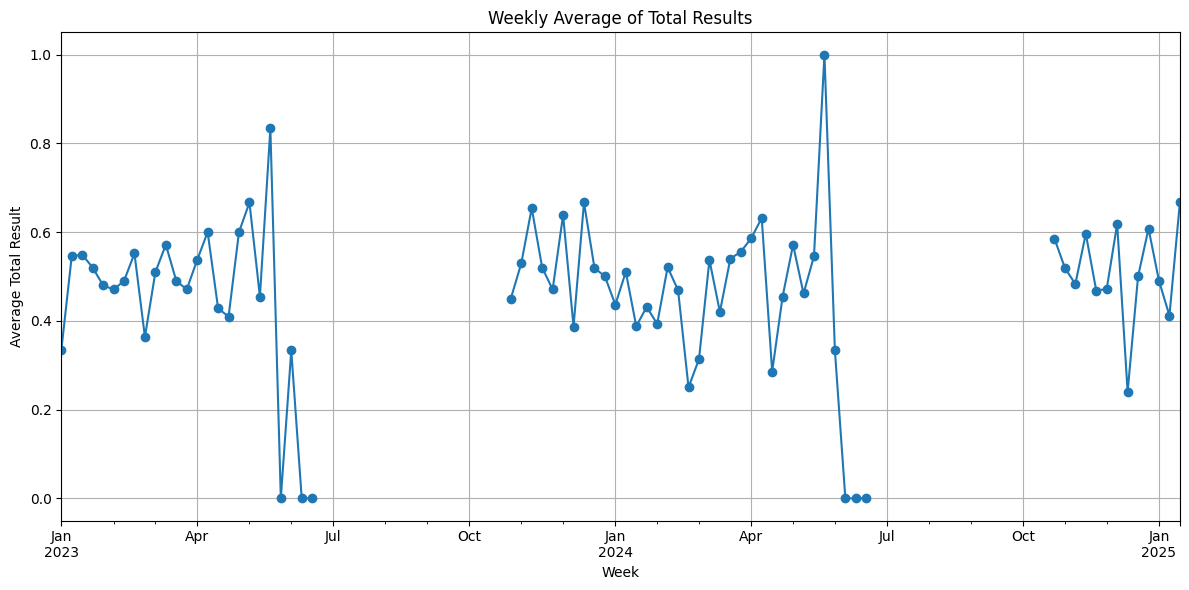

In [168]:
# Ensure 'DATE' is in datetime format
historical_data['DATE'] = pd.to_datetime(historical_data['DATE'])

this_year_data = historical_data[historical_data['DATE'].dt.year >= 2023]
# Convert 'total_result' to integer
this_year_data['total_result'] = historical_data['total_result'].astype(int)

#list of freq values
#freq_values = ['D', 'W', 'M', 'Q', 'Y']
# Group by week using Grouper and calculate the mean
weekly_data = this_year_data.groupby(pd.Grouper(key='DATE', freq='W'))['total_result'].mean()

# Plot the weekly average of 'total_result'
plt.figure(figsize=(12, 6))
weekly_data.plot(marker='o', linestyle='-')
plt.title('Weekly Average of Total Results')
plt.xlabel('Week')
plt.ylabel('Average Total Result')
plt.grid(True)
plt.tight_layout()
plt.show()
